In [54]:
#! pip install yfinance --upgrade --no-cache-dir

In [55]:
#!pip install tweepy

In [56]:
#!pip install textblob

In [57]:
#!pip install scikit-learn

In [58]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Master
[nltk_data]     Bustache\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
import yfinance as yf
import datetime as dt
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates


import numpy as np
import pandas as pd
import tweepy
import csv
import sys

from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from textblob import TextBlob

import constants as ct
from Tweet import Tweet

style.use('ggplot')

In [60]:
def check_stock_symbol(flag=False, companies_file='companylist.csv'):
    df = pd.read_csv(companies_file, usecols=[0])

    while flag is False:
        symbol = input('Enter a stock symbol to retrieve data from: ').upper()
        for index in range(len(df)):
            if df['Symbol'][index] == symbol:
                flag = True
    return flag, symbol

In [61]:
def get_stock_data(symbol, from_date, to_date):
    data = yf.download(symbol, start=from_date, end=to_date)
    df = pd.DataFrame(data=data)

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df['HighLoad'] = (df['High'] - df['Close']) / df['Close'] * 100.0
    df['Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Close', 'HighLoad', 'Change', 'Volume']]
    
    print(to_date)
    df['Close'].plot(color='black')
    plt.show()
    return df

In [62]:
def stock_forecasting(df):
    forecast_col = 'Close'
    #df.fillnan(value=-99999, inplace=True)
    forecast_out = int(math.ceil(0.001*len(df)))
    df['Label'] = df[[forecast_col]].shift(-forecast_out)

    X = np.array(df.drop(['Label'], axis=1))
    X = preprocessing.scale(X)
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]

    df.dropna(inplace=True)
    y = np.array(df['Label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    forecast_set = clf.predict(X_lately)

    df['Prediction'] = np.nan

    last_date = df.iloc[-1].name
    print(last_date)
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day

    for i in forecast_set:
        next_date = dt.datetime.fromtimestamp(next_unix)
        next_unix += 86400
        df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
        #print(df.loc[next_date])
    
    df['Close'].plot(color='black')
    plt.show()
    #print(df)
    
    return df, forecast_out

In [63]:
def forecast_plot(df):
    ax = df['Close'].plot(color='black')
    df['Prediction'].plot(color='green')
    plt.legend(loc=4)
    #ax.xaxis
    #ax.xaxis.set_major_locator(mticker.MaxNLocator(9))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    #okay = 0
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(45)
        #label[okay] = str(label)[:7]
        #okay += 1
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    #print(df.index)
    #ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

In [64]:
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            time.sleep(16 * 60)
        except StopIteration:
            return

In [65]:
def retrieving_tweets_polarity(symbol):
    auth = tweepy.OAuthHandler(ct.consumer_key, ct.consumer_secret)
    auth.set_access_token(ct.access_token, ct.access_token_secret)
    user = tweepy.API(auth, retry_count=3, retry_delay=5, retry_errors=set([401, 404, 426, 429, 500, 503]), 
                      wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    
    #tweets = tweepy.Cursor(user.search,q=str(symbol), lang="en",  since="2020-01-01" , until="2020-01-02").items()
    tweets = tweepy.Cursor(user.search, q=str(symbol), tweet_mode='extended', lang='en').items(ct.num_of_tweets)
    
    tweet_list = []
    global_polarity = 0
    for tweet in limit_handled(tweets):
        #print(tweet.created_at, tweet.full_text)
        tw = tweet.full_text
        blob = TextBlob(tw)
        polarity = 0
        for sentence in blob.sentences:
            polarity += sentence.sentiment.polarity
            global_polarity += sentence.sentiment.polarity
        tweet_list.append(Tweet(tw, polarity))
    print(len(tweet_list))
    global_polarity = global_polarity / len(tweet_list)
    print(global_polarity)
    return global_polarity

In [66]:
def recommending(df, forecast_out, global_polarity):
    if df.iloc[-forecast_out-1]['Close'] < df.iloc[-1]['Prediction']:
        if global_polarity > 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a GREAT idea!" % str(symbol))
        elif global_polarity < 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))
    else:
        print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))

Enter a stock symbol to retrieve data from: aapl
Stock Symbol: AAPL
Stock Name: Apple Inc.
Retrieving Stock Data from  Apple Inc. ...
[*********************100%***********************]  1 of 1 completed
2020-01-28


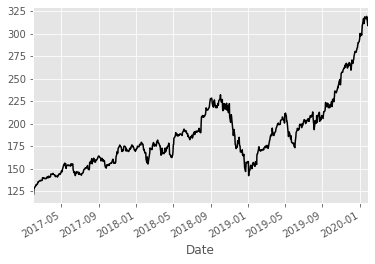

Forecasting stock DataFrame...
2020-01-27 00:00:00


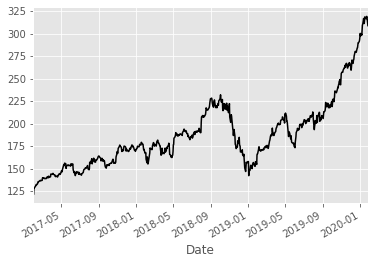

Plotting existing and forecasted values...


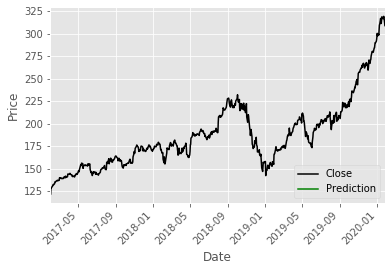

Retrieving AAPL related tweets polarity...


Rate limit reached. Sleeping for: 525
Rate limit reached. Sleeping for: 842
Rate limit reached. Sleeping for: 847


In [ ]:
if __name__ == "__main__":
    (flag, symbol) = check_stock_symbol(False, 'companylist.csv')
    if flag:
        
        actual_date = dt.date.today()
        past_date = actual_date - dt.timedelta(days=365 * 3)
    
    
        actual_date = actual_date.strftime("%Y-%m-%d")
        past_date = past_date.strftime("%Y-%m-%d")
        
        df = pd.read_csv('companylist.csv')
        work = df.loc[df['Symbol'] == symbol]
        sym = work['Symbol'].to_string(index=False)
        name = work['Name'].to_string(index=False)
        print("Stock Symbol: %s" % symbol)
        print("Stock Name:%s" % name)
        #print(df.loc[df['Symbol'] == symbol])
        
        #print(name)
        print ("Retrieving Stock Data from", name, "...")
        dataframe = get_stock_data(symbol, past_date, actual_date)
        print ("Forecasting stock DataFrame...")
        (dataframe, forecast_out) = stock_forecasting(dataframe)
        print ("Plotting existing and forecasted values...")
        forecast_plot(dataframe)
        print ("Retrieving %s related tweets polarity..." %symbol)
        polarity = retrieving_tweets_polarity(symbol)
        print ("Generating recommendation based on prediction & polarity...")
        recommending(dataframe, forecast_out, polarity)